# $\Lambda\mathrm{CDM}$

## $\mathrm{Training~Data:~} T(k| h, \omega_b, \omega_m)$

In [6]:
from classy import Class
import numpy as np
import os

In [7]:
# Grid of 4x4x4
obh2vals = np.linspace(0.0214,0.0234, 4)
omh2vals = np.linspace(0.13, 0.15, 4)
hvals = np.linspace(0.65, 0.75, 4)

In [8]:
# To store data
Store = []

for i in range(len(obh2vals)):
    for j in range(len(omh2vals)):
        for l in range(len(hvals)):
            params = {
                'output': 'mTk', 
                'h': hvals[l], 
                'omega_b': obh2vals[i], 
                'omega_cdm': omh2vals[j] - obh2vals[i],
            }
            print("Now running class for model ",i," ",j," ", l)
            
            cosmo = Class()
            cosmo.set(params)
            cosmo.compute()
            perturbations_z0 = cosmo.get_transfer()
            
            k = perturbations_z0['k (h/Mpc)'] 
            omega_b = np.array([obh2vals[i] for m in range(len(k))])
            omega_m = np.array([omh2vals[j] for m in range(len(k))])
            h = np.array([hvals[l] for m in range(len(k))])
            phi = perturbations_z0['phi']
            
            datadeltak = np.array(list(zip(k, h, omega_b, omega_m, phi)))
            Store = np.append(Store, datadeltak, axis = None)
Data = Store.reshape(int(len(Store)/5), 5)

Now running class for model  0   0   0
Now running class for model  0   0   1
Now running class for model  0   0   2
Now running class for model  0   0   3
Now running class for model  0   1   0
Now running class for model  0   1   1
Now running class for model  0   1   2
Now running class for model  0   1   3
Now running class for model  0   2   0
Now running class for model  0   2   1
Now running class for model  0   2   2
Now running class for model  0   2   3
Now running class for model  0   3   0
Now running class for model  0   3   1
Now running class for model  0   3   2
Now running class for model  0   3   3
Now running class for model  1   0   0
Now running class for model  1   0   1
Now running class for model  1   0   2
Now running class for model  1   0   3
Now running class for model  1   1   0
Now running class for model  1   1   1
Now running class for model  1   1   2
Now running class for model  1   1   3
Now running class for model  1   2   0
Now running class for mod

In [9]:
np.savetxt('Data/Transfer_Function_h_omegab_omegam.txt', Data)

In [10]:
print("Length of arrays: ", len(k), " data points for each model...")
print(Data.shape[0]/len(k))

Length of arrays:  114  data points for each model...
64.0


## $\mathrm{Test~Data:~} P(k| h, \omega_b, \omega_m, n_s, A_s)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sys
import os

In [2]:
def get_param_samples(n, seed):
    """
    Get n samples from a latin hypercube from uniform prior
    
    Args:
        :n (int): Number of sets of cosmological samples to obtain
        :seed (int): The random seems for the latin hypercube
        
    Returns:
        :cosmo_params (np.ndarray): Array of cosmological parameters of shape (n, number of parameters).
            The parameters are ordered h, omega_b, omega_m, ns, 10^9 As
    """
    
    all_prior = [[0.65, 0.75],    # h
                 [0.0214, 0.0234],  # omega_b 
                 [0.13, 0.15],  # omega_m 
                 [0.90, 1.00],  # ns
                 [1.5, 2.5],  # As 10⁹
                ]

    # Generate samples
    d = len(all_prior)
    lh_sampler = stats.qmc.LatinHypercube(d, seed=seed)
    cosmo_params = lh_sampler.random(n)
    for i in range(d):
        cosmo_params[:,i] = all_prior[i][0] + (all_prior[i][1] - all_prior[i][0]) * cosmo_params[:,i]
        
    return cosmo_params

In [34]:
#generate cosmological parameter samples
thetas = get_param_samples(200, 3)

#set up k values
kmin = 1e-5
kmax = 1.5
nk = 200
ks = np.logspace(np.log10(kmin), np.log10(kmax), nk)

In [ ]:
# set up CLASS for comparison
from classy import Class
from classy import CosmoComputationError
import warnings

def get_class_linear(k, h, omega_b, omega_m, ns, As_e9):
    """
    Compute linear P(k) using class for the cosmology of interest
    
    Args:
        :k (np.ndarray): k values in [h/Mpc]
        :omega_b (float): baryonic reduced density parameter,
        :omega_m (float): matter reduced density parameter,
        :h (float): reduced Hubble constant
        :ns (float): Spectral tilt of primordial power spectrum
        :As_e9 (float): 10^9 times the amplitude of the primordial P(k)
        
    Returns:
        :plin_class (np.ndarray): Linear power spectrum at corresponding k values [(Mpc/h)^3]
    """
    
    class_params = {
        'h': h,
        'omega_b': omega_b,
        'omega_cdm': omega_m - omega_b,
        'n_s': ns,
        'A_s': As_e9*1.e-9,
        'output': 'mPk',
        'P_k_max_1/Mpc': k.max() * h,
    }
        
    cosmo = Class()
    cosmo.set(class_params)

    try:
        cosmo.compute()
    except CosmoComputationError as e:
        if "DeltaNeff < deltaN[0]" in str(e):
            # set YHe to 0.25. Value is from https://arxiv.org/abs/1503.08146 and Plank 2018(Section 7.6.1) https://arxiv.org/abs/1807.06209
            warnings.warn(f"Adjust YHe to 0.25 due to CLASS CosmoComputationError for cosmology {class_params}.")
            class_params['YHe'] = 0.25
            cosmo.set(class_params)
            cosmo.compute()
        else:
            raise e

    plin_class = np.array([cosmo.pk_lin(kk*h, 0) for kk in k]) * h ** 3

    # sigma8 from CLASS
    sigma8 = cosmo.sigma8()
    
    # Memory cleanup for class
    cosmo.struct_cleanup()
    cosmo.empty()

    return plin_class, sigma8

In [ ]:
output_dir = "./Data/spectra_latin_hc/"
os.makedirs(output_dir, exist_ok=True)

plin_class = []
sigma8_values = []

# Compute espectra and sigma8 for each cosmology
for i, t in enumerate(thetas):
    pk, sigma8 = get_class_linear(ks, *t)
    plin_class.append(pk)
    sigma8_values.append(sigma8)

    fname = os.path.join(output_dir, f"spectrum_{i + 1:03d}.txt")
    np.savetxt(fname, np.column_stack([ks, pk]), header="k  P(k)", comments='')

In [6]:
params = np.column_stack([thetas, sigma8_values])
header = "h omega_b omega_m ns 10^9As sigma8"
np.savetxt("./Data/cosmo_params.txt", params, header=header, comments='', fmt="%.8f")

### $\mathrm{Performance:~Ce~Sui~et~al}$

In [7]:
# Add the path to the symbolic_pofk module
sys.path.append('/home/bayron/symbolic_pofk/symbolic_pofk')

from linear_new import plin_new_emulated
from syren_new import pnl_new_emulated

In [22]:
# define plot function for the test

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": 16,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "axes.linewidth": 1,
    "xtick.major.width": 1,
    "ytick.major.width": 1
})

def plot_diff(ks, preds, truth):
    rela_diffs = (preds - truth) / truth
    percentiles =  np.percentile(rela_diffs, [50-34-13.6,50-34, 50, 50+34,50+34+13.6], axis=0)
    
    fig, ax = plt.subplots(figsize=(6,4))

    # Colors matching Mathematica EXACT RGB
    color2s = (0.890, 0.102, 0.110)     # red
    color1s = (0.121, 0.466, 0.705)     # blue
    
    ax.plot(ks, percentiles[2], color='black', linewidth=2)
    ax.fill_between(ks, percentiles[0], percentiles[-1], color=color2s, alpha=1, label=r'$2\sigma$')
    ax.fill_between(ks, percentiles[1], percentiles[-2], color=color1s, alpha=1, label=r'$1\sigma$')
    
    ax.axhline(0, color='k', linestyle='--')
    ax.axhline(0.01, color='k', linestyle='--')
    ax.axhline(-0.01, color='k', linestyle='--')
    
    ax.set_xscale('log')
    ax.set_xlim(ks[94],ks[-1])
    ax.set_xlabel(r'$k~[h\,\mathrm{Mpc}^{-1}]$')
    ax.set_ylabel(r'$\Delta P_\mathrm{lin}/P_\mathrm{lin, True}$')

    ax.set_title(r'$\mathrm{Ce~Sui~et~al}$')
    
    leg = ax.legend(loc='lower left', frameon=True)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(1.2)

    plt.savefig("CeSui_etal.pdf", format="pdf", bbox_inches='tight')
    plt.tight_layout()
    plt.show()

In [ ]:
# thetas = [10^9 As, Om, Ob, h, ns] for symbolic_pofk
thetas_SN = []

for h, ob, om, ns, As in thetas:
    Ob = ob / h**2   # Baryon density parameter
    Om = om / h**2   # Matter density parameter
    thetas_SN.append([As, Om, Ob, h, ns])

thetas_SN = np.array(thetas_SN)

In [40]:
%%time
# Compute the linear power spectrum using emulator 
plin_preds = [plin_new_emulated(ks,*t, 0, -1, 0) for t in thetas_SN]

CPU times: user 23.7 ms, sys: 61 μs, total: 23.8 ms
Wall time: 23.3 ms


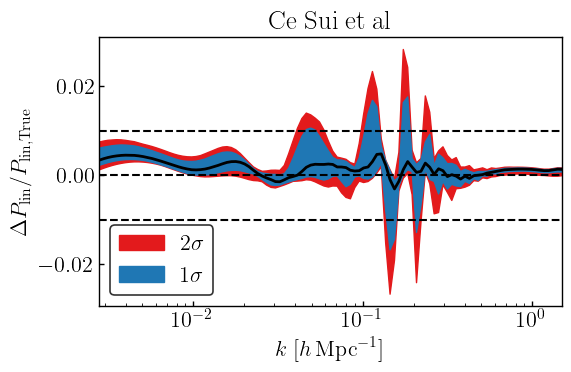

In [41]:
plin_preds = np.array(plin_preds)
plin_class = np.array(plin_class)

plot_diff(ks, plin_preds, plin_class)

In [ ]:
# Only compute for k > 0.009 [h/Mpc]
relative_errors = np.abs(1 - (plin_preds[:, 114:] / plin_class[:, 114:])) * 100
mean_errors = np.mean(relative_errors, axis=1)
global_mean_error = np.mean(relative_errors)
print('MAPE(CeSui) =', global_mean_error, '%')

MAPE(CeSui) = 0.24679870772740625 %


## $\mathrm{Non~Linear~Spectra}$

In [22]:
import numpy as np
from scipy import stats
import subprocess
import os

In [ ]:
# Path to CLASS exec
CLASS_BIN = "/home/bayron/class_public/class"
# Path to the .ini template
INI_PATH = "/home/bayron/class_public/models/Wiggles/HaloFIT.ini"

In [ ]:
def modificar_ini(path, params):
    """
    Overwrite cosmo params and change the root for each entry
    """

    h, ob, om, ns, As9 = params
    oc = om - ob                # CLASS uses omega_cdm
    As = As9 * 1e-9             # Replace (10^9 As) → As

    with open(path, "r") as f:
        lines = f.readlines()

    with open(path, "w") as f:
        for line in lines:

            if line.startswith("h "):
                f.write(f"h = {h}\n")
            elif line.startswith("omega_b"):
                f.write(f"omega_b = {ob}\n")
            elif line.startswith("omega_cdm"):
                f.write(f"omega_cdm = {oc}\n")
            elif line.startswith("n_s"):
                f.write(f"n_s = {ns}\n")
            elif line.startswith("A_s"):
                f.write(f"A_s = {As}\n")
            else:
                f.write(line)

#  Function to execute CLASS
def run_class():
    subprocess.run([CLASS_BIN, INI_PATH])

In [26]:
for i, params in enumerate(thetas):
    modificar_ini(INI_PATH, params)
    run_class()

## $\mathrm{Data~for~} k_\mathrm{max}$

In [1]:
import numpy as np
from classy import Class
import os

In [ ]:
# Reference values for the params
h_ref = 0.65
omega_b_ref = 0.0214
omega_m_ref = 0.13
ns_ref = 0.9
As_e9_ref = 1.5

# Define grids
h_vals = np.linspace(0.65, 0.75, 25)
omega_b_vals = np.linspace(0.0214, 0.0234, 25)
omega_m_vals = np.linspace(0.13, 0.15, 25)
ns_vals = np.linspace(0.9, 1.0, 25)
As_vals = np.linspace(1.5, 2.5, 25)

# Set up k values
kmin = 1e-4
kmax = 1.5
nk = 150
ks = np.logspace(np.log10(kmin), np.log10(kmax), nk)

In [ ]:
# Output folder
output_dir = "./Data/Spectra_kmax"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Function to compute and save the spectra
def get_class_Pk(name, h, omega_b, omega_m, ns, As_e9):
    cosmo = Class()
    params = {
        'h': h,
        'omega_b': omega_b,
        'omega_cdm': omega_m - omega_b,
        'n_s': ns,
        'A_s': As_e9 * 1e-9,
        'output': 'mPk',
        'P_k_max_1/Mpc': ks.max() * h
    }
    cosmo.set(params)
    cosmo.compute()
    pk_vals = np.array([cosmo.pk_lin(k * h, 0) for k in ks]) * h ** 3
    cosmo.struct_cleanup()
    cosmo.empty()

    np.savetxt(f"{output_dir}/spectrum_{name}.txt", np.column_stack((ks, pk_vals)), fmt="%.8e")

In [ ]:
# Vary one parameter at once
for i, h in enumerate(h_vals):
    get_class_Pk(f"h_{i}", h, omega_b_ref, omega_m_ref, ns_ref, As_e9_ref)

for i, omega_b in enumerate(omega_b_vals):
    get_class_Pk(f"omega_b_{i}", h_ref, omega_b, omega_m_ref, ns_ref, As_e9_ref)

for i, omega_m in enumerate(omega_m_vals):
    get_class_Pk(f"omega_m_{i}", h_ref, omega_b_ref, omega_m, ns_ref, As_e9_ref)

for i, ns in enumerate(ns_vals):
    get_class_Pk(f"ns_{i}", h_ref, omega_b_ref, omega_m_ref, ns, As_e9_ref)

for i, As_e9 in enumerate(As_vals):
    get_class_Pk(f"As_{i}", h_ref, omega_b_ref, omega_m_ref, ns_ref, As_e9)